In [57]:
import laspy as lp
import numpy as np
import matplotlib.pyplot as plt


def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)

In [58]:
DATE = 250329
POZA = 'km11'
PATH_LAS = f'data/{DATE}_100m_7ms_100khz_plena_luz/pozas/{POZA}_100m_7ms_100khz_plena-luz_0_0.las' 

LIMIT = -1

rasantes = {
    'km11': 2300.382,  
    'km12': 2300.345,   
    'km13': 2300.372,
    '3a': 2300.305,
    '2a': 2300.700,
    'pam2': 2300.618  
}

salmueras = {
    'km11': 2300.866,
    'km12': 2300.582,
    'km13': 2300.647,
    'pam2': 2302.185,
    '2a': 2301.129,
    '3a': 2300.978
}

rasante = rasantes.get(POZA, None)
c_salmuera = salmueras.get(POZA, None)

In [59]:
from pyproj import CRS
las = read_las_file(PATH_LAS)

points = np.vstack((las.x, las.y, las.z)).transpose()
data_points = np.hstack((points,
                        np.expand_dims(las.return_number, -1),
                        np.expand_dims(las.number_of_returns, -1)))

print(f'{POZA}')

first = data_points[(data_points[:,-2] == 1) & (data_points[:,-1] == 2)][:, :3]
#salmuera = np.mean(first[:,2])
#print(f'Cota Salmuera: {salmuera}')

one_return = data_points[(data_points[:, -1] == 1)][:, :3]
#one_return = one_return[one_return[:,2] >= rasante]  # remove noise
#one_return = one_return[one_return[:,2] <= salmuera] # con la salmuera detectada por el lidar
#one_return = one_return[one_return[:,2] <= c_salmuera] # con la salmuera dada por sqm

#first_bottom = first[first[:,2] <= c_salmuera]
#one_return = np.vstack((one_return, first_bottom))

print(f'Cota Sal Promedio: {np.mean(one_return[:,2])}')



km11
Cota Sal Promedio: 2300.9664036367094


In [60]:
import numpy as np
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator
import rasterio
from rasterio.transform import from_origin

x, y, z = one_return[:,0], one_return[:,1], one_return[:,2] - rasante
z = np.clip(z, 0, 4)

# 3. Calcular espaciado automático 
point_spacing = np.mean(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
grid_spacing = point_spacing 
print(f'Resolución del DEM: {grid_spacing} m')

# 4. Crear cuadrícula
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

cols = int(np.ceil((x_max - x_min) / grid_spacing))
rows = int(np.ceil((y_max - y_min) / grid_spacing))

# 5. Binning para promedio
grid_sum = np.zeros((rows, cols))
grid_count = np.zeros((rows, cols))

xi = ((x - x_min) / grid_spacing).astype(int)
yi = ((y_max - y) / grid_spacing).astype(int)

np.add.at(grid_sum, (yi, xi), z)
np.add.at(grid_count, (yi, xi), 1)

dem = np.divide(grid_sum, grid_count, where=grid_count != 0)
dem[grid_count == 0] = np.nan

# --- Interpolación combinada lineal + nearest ---
mask = ~np.isnan(dem)
y_coords, x_coords = np.where(mask)

xx = x_min + (x_coords + 0.5) * grid_spacing
yy = y_max - (y_coords + 0.5) * grid_spacing

# Primera interpolación: Lineal
linear_interp = LinearNDInterpolator(list(zip(xx, yy)), dem[mask])

grid_x, grid_y = np.meshgrid(
    x_min + (np.arange(cols) + 0.5) * grid_spacing,
    y_max - (np.arange(rows) + 0.5) * grid_spacing
)

dem_filled = dem.copy()
nan_mask = np.isnan(dem)
dem_filled[nan_mask] = linear_interp(grid_x[nan_mask], grid_y[nan_mask])

# Segunda interpolación: Nearest para NaN residuales
if np.isnan(dem_filled).any():
    print("Aplicando Nearest para NaN residuales")
    nearest_interp = NearestNDInterpolator(list(zip(xx, yy)), dem[mask])
    residual_nan = np.isnan(dem_filled)
    dem_filled[residual_nan] = nearest_interp(grid_x[residual_nan], grid_y[residual_nan])

# 7. Guardar el DEM interpolado
transform = from_origin(
    x_min - grid_spacing/2, 
    y_max + grid_spacing/2, 
    grid_spacing, 
    grid_spacing
)

with rasterio.open(
    f"dems/{POZA}.tiff",
    'w',
    driver='GTiff',
    height=rows,
    width=cols,
    count=1,
    dtype=dem_filled.dtype,
    crs=None,
    transform=transform,
) as dst:
    dst.write(dem_filled, 1)  # Guardar la versión interpolada

print("DEM generado con interpolación lineal + nearest!")

Resolución del DEM: 0.17378910858337693 m
Aplicando Nearest para NaN residuales
DEM generado con interpolación lineal + nearest!


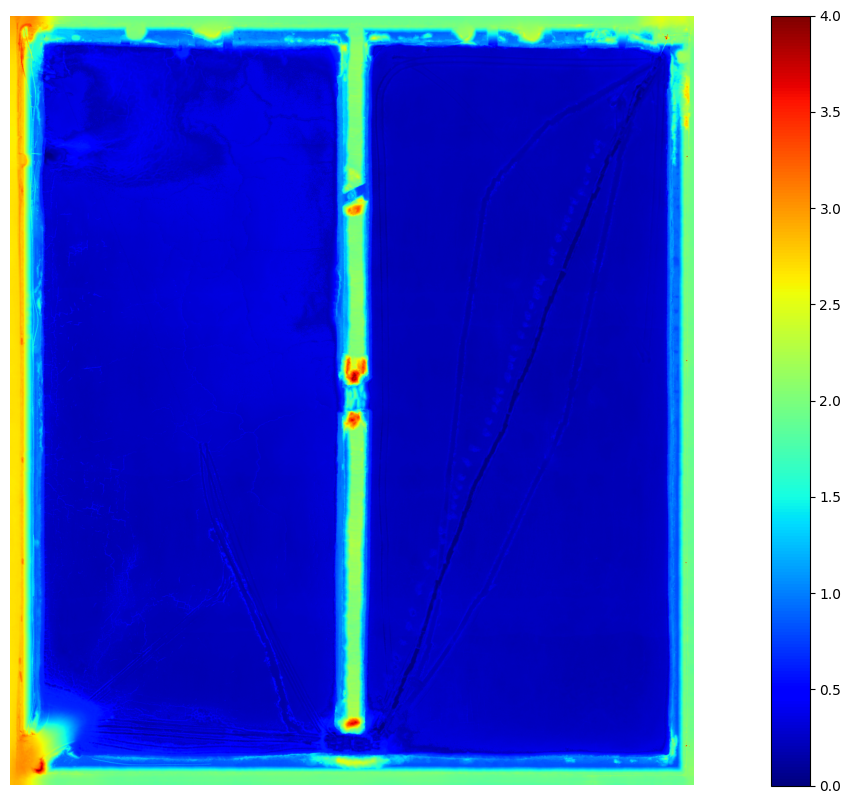

(1741, 1546)

In [66]:
plt.figure(figsize=(20,10))
plt.imshow(dem_filled, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()
dem.shape

In [62]:
# import rasterio
# import matplotlib.pyplot as plt

# tiff_path = f'dems/{POZA}.tiff'
# output_path = f'{tiff_path.split(".")[0]}.png'

# with rasterio.open(tiff_path) as src:
#     data = src.read()
    
#     # Print basic information about the raster
#     print(f'Number of bands: {src.count}')
#     print(f'Width: {src.width}')
#     print(f'Height: {src.height}')
#     print(f'CRS: {src.crs}')
#     print(f'Transform: \n{src.transform}')
#     print(f'Data type: {src.dtypes[0]}')

#     # Display the image
#     if src.count == 1:
#         plt.figure(figsize=(20,10))
#         plt.imshow(data[0], cmap='jet')
#     else:
#         plt.imshow(data.transpose(1, 2, 0))

#     plt.title(f'Maps Salt {POZA.upper()}')
#     plt.colorbar()
#     plt.axis('off') 
#     plt.savefig(output_path, dpi=300, bbox_inches='tight')
#     plt.show()

In [63]:
import os 
import cv2
import numpy as np

def bresenham_line(start=(10, 10), end=(10, 60)):
    """
    Generate a list of points using Bresenham's Line Algorithm.

    This algorithm computes the points between two coordinates (start, end),
    producing a list of tuples representing the line connecting these two points
    based on the principle of rasterizing a line.

    Parameters:
        start (tuple): The starting point of the line as (x1, y1).
        end (tuple): The ending point of the line as (x2, y2).

    Returns:
        list: A list of points (x, y) between the start and end points.

    Examples:
        >>> points1 = generate_bresenham_line((0, 0), (3, 4))
        >>> points2 = generate_bresenham_line((3, 4), (0, 0))
        >>> assert(set(points1) == set(points2))
        >>> print(points1)
        [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
        >>> print(points2)
        [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """

    # Unpack start and end points
    x1, y1 = np.array(start, dtype=np.int32).copy()
    x2, y2 = np.array(end, dtype=np.int32).copy()


    # Calculate differences
    dx = x2 - x1
    dy = y2 - y1

    # Determine if the line is steep (more vertical than horizontal)
    is_steep = abs(dy) > abs(dx)

    # Swap coordinates if the line is steep (for easier handling)
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Ensure the line is always drawn left-to-right
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1

    # Recalculate differences after the possible swap
    dx = x2 - x1
    dy = y2 - y1

    # Error term initialized to half of dx
    error = dx // 2
    ystep = 1 if y1 < y2 else -1  # Determines whether to increment or decrement y

    # List to store the generated points
    points = []
    y = y1

    # Main loop for Bresenham's algorithm
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)  # Swap x and y if the line is steep
        points.append(coord)

        # Update error term
        error -= abs(dy)

        # If error is negative, adjust y and reset the error term
        if error < 0:
            y += ystep
            error += dx

    return points


w, h = dem_filled.shape
print(w,h)
diagonal_1 = bresenham_line(start=(0,0), end=(w-1,h-1))
diagonal_2 = bresenham_line(start=(0,h-1), end=(w-1,0))



1741 1546


In [64]:
values_diagonal_1 = np.array([dem_filled[x,y] for x, y in diagonal_1])
values_diagonal_2 = np.array([dem_filled[x,y] for x, y in diagonal_2])

indices_diagonal_1 = np.arange(len(values_diagonal_1))
indices_diagonal_2 = np.arange(len(values_diagonal_2))


mean_diagonal1 = np.mean(values_diagonal_1)
mean_diagonal2 = np.mean(values_diagonal_2)

import json

file = {
    "diagonal1" : {
        "unit": "[m]",
        "mean": mean_diagonal1,
        "x_axis": indices_diagonal_1.tolist(),
        "y_axis": values_diagonal_1.tolist(),
    },
    "diagonal2" : {
        "unit": "[m]",
        "mean": mean_diagonal2,
        "x_axis": indices_diagonal_1.tolist(),
        "y_axis": values_diagonal_2.tolist(),
    }
}

with open(f'dems/{POZA}.json', 'w') as json_file:
    json.dump(file, json_file, indent=4)

In [65]:
len(indices_diagonal_1), len(indices_diagonal_2)

(1741, 1741)